社团结构划分，使用CNM算法，导入真实数据集进行测试

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import igraph as ig

使用igraph构建网络的简单操作

In [4]:
g=ig.Graph()
g = ig.Graph(n=10, edges=[[0, 1], [0, 5]])
print(g)
ig.summary(g)

IGRAPH U--- 10 2 --
+ edges:
0--1 0--5
IGRAPH U--- 10 2 -- 


生成一个ER随机图网络进行测试，输出对应的返回值和dendrogram，进行绘图

IGRAPH U--- 10 20 -- 
<class 'igraph.clustering.VertexDendrogram'>
Dendrogram, 10 elements, 9 merges
[(3, 1), (6, 10), (2, 0), (4, 12), (5, 9), (7, 14), (11, 8), (15, 13), (17, 16)]


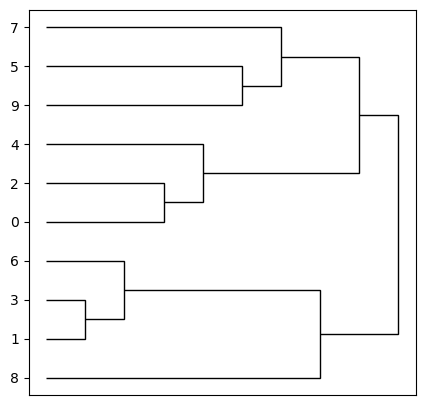

In [128]:
#generate a random network with ig
g=ig.Graph.Erdos_Renyi(n=10,m=20)
ig.summary(g)
dendrogram=g.community_fastgreedy()
print(type(dendrogram))
#renturn type: igraph.clustering.VertexDendrogram
print(dendrogram.summary())
mergeMatrix=dendrogram.merges
print(mergeMatrix)
fig,ax=plt.subplots(figsize=(5,5))
dendrogram.__plot__(backend='matplotlib',context=ax)
plt.show()


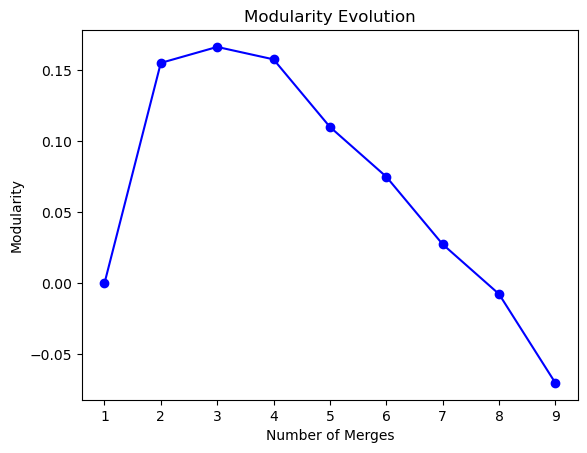

In [131]:
# Get the modularity values and number of merges
merges = range(1, len(dendrogram.merges) + 1)
modularity = []

# Calculate modularity at each merge step
for merge in merges:
    clusters = dendrogram.as_clustering(merge)
    modularity.append(clusters.modularity)

# Plot modularity evolution
plt.plot(merges, modularity, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Merges')
plt.ylabel('Modularity')
plt.title('Modularity Evolution')
plt.show()

加载真实网络数据集进行测试，观察模块度的变化过程

In [143]:
#加载真实网络数据集
# 3. 蛋白质交互网络
df3 = pd.read_csv("./real-data/citation.csv")
G1 = nx.from_pandas_edgelist(df3, 'source', 'target', create_using = nx.Graph())
G1=nx.to_undirected(G1)
Matrix=nx.adjacency_matrix(G1)
Matrix=Matrix.todense()
G=ig.Graph.Adjacency(Matrix.tolist())
ig.summary(G)
G.to_undirected()
print(G.is_directed())

IGRAPH D--- 23133 186936 -- 
False


In [162]:
result=G.community_fastgreedy()
print(result.summary())
print(len(result.merges))
print(result.optimal_count)

Dendrogram, 23133 elements, 22566 merges
22566
820


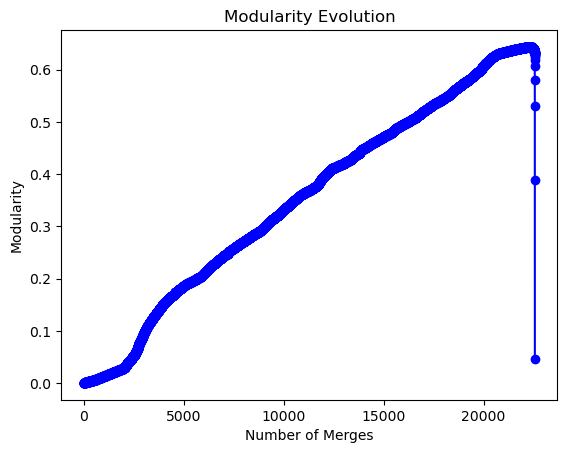

In [174]:
node_nums=G.vcount()
# Get the maximum number of merges available
max_merges = len(result.merges)
merges=range(1,max_merges+1)
modularity = []
for merge in merges:
    clusters=result.as_clustering(node_nums-merge)
    modularity.append(clusters.modularity)
plt.plot(merges,modularity,marker='o',linestyle='-',color='b')
plt.xlabel('Number of Merges')
plt.ylabel('Modularity')
plt.title('Modularity Evolution')
plt.show()

使用BGLL算法进行社团检测，初始时将每个节点作为一个社团，逐步合并

In [183]:
BGLL=G.community_multilevel(return_levels=True)
print(type(BGLL))
print(type(BGLL[0]))
BGLL_len=len(BGLL)
for i in range(BGLL_len):
    print(BGLL[i].summary())

<class 'list'>
<class 'igraph.clustering.VertexClustering'>
Clustering with 23133 elements and 4186 clusters
Clustering with 23133 elements and 1127 clusters
Clustering with 23133 elements and 661 clusters
Clustering with 23133 elements and 621 clusters


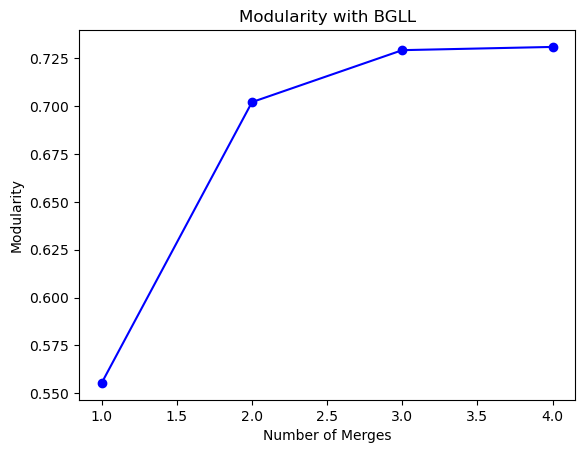

In [185]:
merges=range(1,BGLL_len+1)
modularity=[]
for merge in range(BGLL_len):
    clusters=BGLL[merge]
    modularity.append(clusters.modularity)
plt.plot(merges,modularity,marker='o',linestyle='-',color='b')
plt.xlabel('Number of Merges')
plt.ylabel('Modularity')
plt.title('Modularity with BGLL')
plt.show()

In [199]:
clusterGraph=BGLL[0].cluster_graph()
clusterGraph3=BGLL[3].cluster_graph()
clusterGraph3.write_edgelist("clusterGraph3.csv")
print(clusterGraph.summary())
for i in range(BGLL_len):
    print(G.modularity(membership=BGLL[i].membership))

IGRAPH U--- 4186 17712 -- 
0.5553537739104515
0.7021455202971065
0.7293042899302505
0.7309942005396067
